<a href="https://colab.research.google.com/github/AshwinDeshpande96/Employee_Attrition/blob/main/Employee_Attrition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![](./questions.jpeg)

# Customer Status

In [ ]:
from itertools import combinations
import pandas as pd
import re
from datetime import datetime

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from google.colab import data_table

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import NearestNeighbors
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, chi2

import scipy.stats as stats

from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_fscore_support

In [ ]:
%load_ext google.colab.data_table

In [ ]:
data_table.enable_dataframe_formatter()
data_table._DEFAULT_FORMATTERS[float] = lambda x: f"{x:,.7f}"
data_table._DEFAULT_FORMATTERS[int] = lambda x: f"{x:,.0f}"

In [ ]:
customers_columns = ["Customer ID", "Customer Name", "Activation Date", "Current Status"]
transactions_columns = ["Interaction ID", "Time Spent on Site", "Purchase Amount", "Customer ID"]

In [ ]:
customers = pd.read_csv("customers.csv", usecols=customers_columns)
transactions = pd.read_csv("transactions.csv", usecols=transactions_columns)

In [ ]:
customers.head()

,Customer ID,Customer Name,Activation Date,Current Status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
def clean_text(txt):
    txt = txt.strip()
    txt = re.sub(r"\s+", "_", txt)
    txt = txt.lower()
    return txt

In [ ]:
customers_columns

['Customer ID', 'Customer Name', 'Activation Date', 'Current Status']

In [ ]:
customers_columns = [clean_text(column) for column in customers_columns]
transactions_columns = [clean_text(column) for column in transactions_columns]

In [ ]:
customers_columns

['customer_id', 'customer_name', 'activation_date', 'current_status']

In [ ]:
customers.columns = customers_columns
transactions.columns = transactions_columns

In [ ]:
customers.head()

,customer_id,customer_name,activation_date,current_status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   customer_id      5000 non-null   int64 
 1   customer_name    5000 non-null   object
 2   activation_date  5000 non-null   object
 3   current_status   5000 non-null   object
dtypes: int64(1), object(3)
memory usage: 156.4+ KB


In [ ]:
customers["activation_date"] = pd.to_datetime(customers.activation_date)

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      5000 non-null   int64         
 1   customer_name    5000 non-null   object        
 2   activation_date  5000 non-null   datetime64[ns]
 3   current_status   5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.4+ KB


In [ ]:
transactions.head()

,interaction_id,time_spent_on_site,purchase_amount,customer_id
0,4479095440-1000,19.157810,481.330172,1000
1,4479095472-1000,21.088000,505.451138,1000
2,4479095504-1000,20.047809,399.693529,1000
3,4479095536-1000,21.108193,380.090676,1000
4,4479095568-1000,21.030607,432.649775,1000


In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233763 entries, 0 to 233762
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   interaction_id      233763 non-null  object 
 1   time_spent_on_site  233763 non-null  float64
 2   purchase_amount     233763 non-null  float64
 3   customer_id         233763 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ MB


## Sanity checks

### Customer data

#### customer id has to be unique

In [ ]:
customers.shape

(5000, 4)

In [ ]:
customers.customer_id.nunique() == customers.shape[0]

True

#### are there any null values?

In [ ]:
customers.isna().sum()

customer_id        0
customer_name      0
activation_date    0
current_status     0
dtype: int64

### Transaction data

#### interaction_id has to be unique 

In [ ]:
transactions.interaction_id.nunique() == transactions.shape[0]

True

#### all customer_ids in transaction data have to be in customer data

In [ ]:
set(transactions.customer_id) == set(customers.customer_id)

True

#### are there are any null values?

In [ ]:
transactions.isna().sum()

interaction_id        0
time_spent_on_site    0
purchase_amount       0
customer_id           0
dtype: int64

## EDA

### Customers data

In [ ]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   customer_id      5000 non-null   int64         
 1   customer_name    5000 non-null   object        
 2   activation_date  5000 non-null   datetime64[ns]
 3   current_status   5000 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 156.4+ KB


#### What is the range of activation date?

In [ ]:
customers.activation_date.min(), customers.activation_date.max(), customers.activation_date.max() - customers.activation_date.min() 

(Timestamp('2019-12-07 00:00:00'),
 Timestamp('2022-12-06 00:00:00'),
 Timedelta('1095 days 00:00:00'))

#### making sure there is no bias in source data (for activation_date)

(array([737425., 737546., 737669., 737791., 737911., 738034., 738156.,
        738276., 738399., 738521.]),
 <a list of 10 Text major ticklabel objects>)

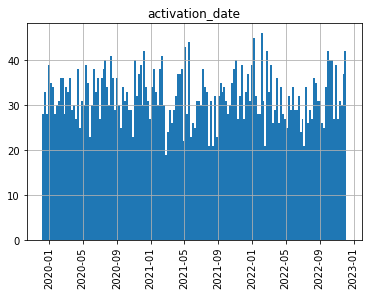

In [ ]:
ax = customers.hist("activation_date", bins=156)
plt.xticks(rotation = 90)

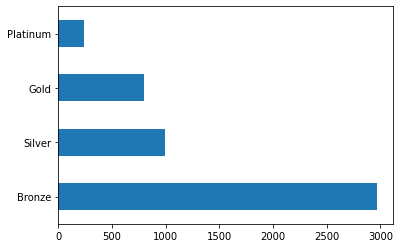

In [ ]:
customers.current_status.value_counts().plot(kind="barh")

### Transactions data

In [ ]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 233763 entries, 0 to 233762
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   interaction_id      233763 non-null  object 
 1   time_spent_on_site  233763 non-null  float64
 2   purchase_amount     233763 non-null  float64
 3   customer_id         233763 non-null  int64  
dtypes: float64(2), int64(1), object(1)
memory usage: 7.1+ MB


#### time_spent_on_site

In [ ]:
print("(min, max): ", transactions.time_spent_on_site.min(), transactions.time_spent_on_site.max())
print("range: ", transactions.time_spent_on_site.max() - transactions.time_spent_on_site.min())

(min, max):  15.423353622268024 24.37915165285658
range:  8.955798030588557


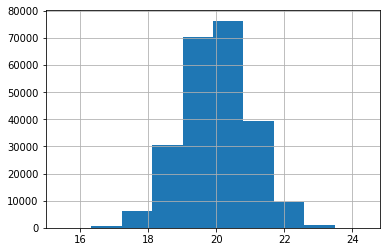

In [ ]:
transactions.time_spent_on_site.hist()

In [ ]:
transactions.time_spent_on_site.describe()

count    233763.000000
mean         20.002156
std           0.999653
min          15.423354
25%          19.328641
50%          20.000443
75%          20.674769
max          24.379152
Name: time_spent_on_site, dtype: float64

#### purchase_amount

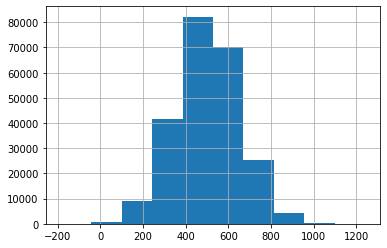

In [ ]:
transactions.purchase_amount.hist()

In [ ]:
transactions.purchase_amount.describe()

count    233763.000000
mean        500.392722
std         150.087326
min        -186.051552
25%         399.187578
50%         500.508585
75%         601.454433
max        1241.386682
Name: purchase_amount, dtype: float64

## let's join!

In [ ]:
df = pd.merge(customers, transactions, on="customer_id", how="inner")

In [ ]:
df.head()

,customer_id,customer_name,activation_date,current_status,interaction_id,time_spent_on_site,purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,4479095440-1000,19.157810,481.330172
1,1000,Bill Floyd,2020-01-05,Gold,4479095472-1000,21.088000,505.451138
2,1000,Bill Floyd,2020-01-05,Gold,4479095504-1000,20.047809,399.693529
3,1000,Bill Floyd,2020-01-05,Gold,4479095536-1000,21.108193,380.090676
4,1000,Bill Floyd,2020-01-05,Gold,4479095568-1000,21.030607,432.649775


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 233763 entries, 0 to 233762
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   customer_id         233763 non-null  int64         
 1   customer_name       233763 non-null  object        
 2   activation_date     233763 non-null  datetime64[ns]
 3   current_status      233763 non-null  object        
 4   interaction_id      233763 non-null  object        
 5   time_spent_on_site  233763 non-null  float64       
 6   purchase_amount     233763 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 14.3+ MB


In [ ]:
df.describe()

,customer_id,time_spent_on_site,purchase_amount
count,233763.000000,233763.000000,233763.000000
mean,3494.988779,20.002156,500.392722
std,1455.456497,0.999653,150.087326
min,1000.000000,15.423354,-186.051552
25%,2229.000000,19.328641,399.187578
50%,3516.000000,20.000443,500.508585
75%,4757.000000,20.674769,601.454433
max,5999.000000,24.379152,1241.386682


In [ ]:
df.customer_id.nunique() == df.shape[0]

False

## customer_name and interaction_id are not useful for prediction

In [ ]:
df = df.drop(columns=["customer_name",  "interaction_id"])

In [ ]:
df.head()

,customer_id,activation_date,current_status,time_spent_on_site,purchase_amount
0,1000,2020-01-05,Gold,19.157810,481.330172
1,1000,2020-01-05,Gold,21.088000,505.451138
2,1000,2020-01-05,Gold,20.047809,399.693529
3,1000,2020-01-05,Gold,21.108193,380.090676
4,1000,2020-01-05,Gold,21.030607,432.649775


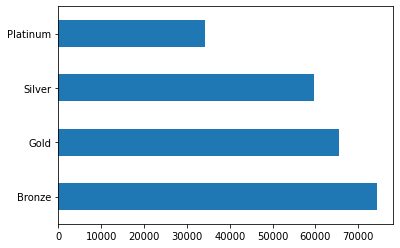

In [ ]:
df.current_status.value_counts().plot(kind="barh")

In [ ]:
customers.current_status.value_counts()

Bronze      2970
Silver       997
Gold         796
Platinum     237
Name: current_status, dtype: int64

In [ ]:
237/2970

0.0797979797979798

In [ ]:
df.current_status.value_counts()

Bronze      74422
Gold        65531
Silver      59568
Platinum    34242
Name: current_status, dtype: int64

In [ ]:
34242/74422

0.46010588266910324

In [ ]:
34242/237

144.48101265822785

In [ ]:
74422/2970

25.057912457912458

* customer data
    * platinum:gold:silver:bronze

* joined df
    * platinum:gold:silver:bronze

since the class imbalance has reduced, we can see that platinum customers may have higher number of transactions compared to bronze

## Feature Engineering

In [ ]:
######### Average purchase amount

now = datetime.now()
def get_num_days_active(activation_date):
    return (now - activation_date).days

######### Minimum purchase amount
def get_min_purchase_amount(customer_purchase_amount):
    return customer_purchase_amount[customer_purchase_amount > 0].min()

######### Average purchase amount
def get_avg_purchase_amount(customer_purchase_amount):
    return customer_purchase_amount[customer_purchase_amount > 0].mean()

######### Q75 purchase amount
def get_q75_purchase_amount(customer_purchase_amount):
    return customer_purchase_amount[customer_purchase_amount > 0].quantile(0.75)

######### Max purchase amount
def get_max_purchase_amount(customer_purchase_amount):
    return customer_purchase_amount.max()


########## purchase amount value categories

# _, pa_mean, pa_std, pa_min, _, _, _, pa_max = transactions.purchase_amount.describe()w
pa_mean = transactions.purchase_amount.mean()
pa_std = transactions.purchase_amount.std()
pa_min = transactions.purchase_amount.min()
pa_max = transactions.purchase_amount.max()

return_pa = [pa_min, 0]
very_low_pa = [0, pa_mean - 2*pa_std]
low_pa = [pa_mean - 2*pa_std, pa_mean - pa_std]
moderate_pa = [pa_mean - pa_std, pa_mean + pa_std]
high_pa = [pa_mean + pa_std, pa_mean + 2*pa_std]
very_high_pa = [pa_mean + 2*pa_std, pa_max]

def get_return_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(return_pa[0], return_pa[1])
    return pa_counts.sum()

def get_very_low_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(very_low_pa[0], very_low_pa[1])
    return pa_counts.sum()

def get_low_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(low_pa[0], low_pa[1])
    return pa_counts.sum()

def get_moderate_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(moderate_pa[0], moderate_pa[1])
    return pa_counts.sum()

def get_high_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(high_pa[0], high_pa[1])
    return pa_counts.sum()

def get_very_high_pa_count(customer_purchase_amounts):
    pa_counts = customer_purchase_amounts.between(very_high_pa[0], very_high_pa[1])
    return pa_counts.sum()


### Average time spent
def get_avg_time_spent(customer_times):
    return customer_times.mean()

### Total time spent
def get_total_time_spent(customer_times):
    return customer_times.sum()




In [ ]:
customer_features = customers.copy()

In [ ]:
customer_features.head()

,customer_id,customer_name,activation_date,current_status
0,1000,Bill Floyd,2020-01-05,Gold
1,1001,Jason Fritz,2022-03-29,Bronze
2,1002,Melissa Flynn,2020-11-28,Gold
3,1003,Aaron Mills,2022-11-14,Gold
4,1004,Kristi Barton,2021-06-21,Bronze


In [ ]:
def add_ft_col(df, ft_series, primary_key, ft_name, how="left"):
    ft_df = ft_series.reset_index()
    ft_df.columns = [primary_key, ft_name]

    return pd.merge(df,
                    ft_df,
                    on=primary_key,
                    how=how
                    )

In [ ]:
feature_columns = []

### Number of days active

In [ ]:
customer_features["num_days_active"] = customer_features.activation_date.apply(get_num_days_active)
feature_columns.append("num_days_active")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active
0,1000,Bill Floyd,2020-01-05,Gold,1071
1,1001,Jason Fritz,2022-03-29,Bronze,257
2,1002,Melissa Flynn,2020-11-28,Gold,743
3,1003,Aaron Mills,2022-11-14,Gold,27
4,1004,Kristi Barton,2021-06-21,Bronze,538


### Minimum Purchase Amount

In [ ]:
min_pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_min_purchase_amount)

customer_features = add_ft_col(customer_features, min_pa_ft, "customer_id", "min_purchase_amount")
feature_columns.append("min_purchase_amount")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385


### Average Purchase Amount

In [ ]:
avg_pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_avg_purchase_amount)

customer_features = add_ft_col(customer_features, avg_pa_ft, "customer_id", "avg_purchase_amount")
feature_columns.append("avg_purchase_amount")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715


### Quantile 75 Purchase Amount

In [ ]:
q75_pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_q75_purchase_amount)

customer_features = add_ft_col(customer_features, q75_pa_ft, "customer_id", "q75_purchase_amount")
feature_columns.append("q75_purchase_amount")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800


### Max Purchase Amount

In [ ]:
max_pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_max_purchase_amount)

customer_features = add_ft_col(customer_features, max_pa_ft, "customer_id", "max_purchase_amount")
feature_columns.append("max_purchase_amount")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070


### Number of times purchase amount value (return, low, very low, moderate, high, very_high)

In [ ]:
num_ret_ft = df.groupby("customer_id")["purchase_amount"].apply(get_return_pa_count)

customer_features = add_ft_col(customer_features, num_ret_ft, "customer_id", "num_returns")
feature_columns.append("num_returns")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_very_low_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_very_low")
feature_columns.append("num_very_low")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_low_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_low")
feature_columns.append("num_low")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_moderate_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_moderate")
feature_columns.append("num_moderate")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_high_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_high")
feature_columns.append("num_high")
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62,8
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21,2
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45,18
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53,9
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17,3


In [ ]:
pa_ft = df.groupby("customer_id")["purchase_amount"].apply(get_very_high_pa_count)

customer_features = add_ft_col(customer_features, pa_ft, "customer_id", "num_very_high")
feature_columns.append("num_very_high")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62,8,0
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21,2,0
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45,18,2
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53,9,1
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17,3,1


### Average Time Spent

In [ ]:
ft_series = df.groupby("customer_id")["time_spent_on_site"].apply(get_avg_time_spent)

customer_features = add_ft_col(customer_features, ft_series, "customer_id", "avg_time_spent")
feature_columns.append("avg_time_spent")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62,8,0,20.148738
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21,2,0,19.871985
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45,18,2,20.003110
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53,9,1,19.845271
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17,3,1,19.518252


### Total Time Spent

In [ ]:
ft_series = df.groupby("customer_id")["time_spent_on_site"].apply(get_total_time_spent)

customer_features = add_ft_col(customer_features, ft_series, "customer_id", "total_time_spent")
feature_columns.append("total_time_spent")

customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent,total_time_spent
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62,8,0,20.148738,1652.196511
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21,2,0,19.871985,576.287567
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45,18,2,20.003110,1560.242589
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53,9,1,19.845271,1369.323665
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17,3,1,19.518252,468.438054


## Index target column to numeric

In [ ]:
le = LabelEncoder()
customer_features["label"] = le.fit_transform(customer_features["current_status"])

In [ ]:
customer_features["current_status"].value_counts()

Bronze      2970
Silver       997
Gold         796
Platinum     237
Name: current_status, dtype: int64

In [ ]:
customer_features.head()

,customer_id,customer_name,activation_date,current_status,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent,total_time_spent,label
0,1000,Bill Floyd,2020-01-05,Gold,1071,154.952423,489.418153,581.960886,760.563456,0,2,10,62,8,0,20.148738,1652.196511,1
1,1001,Jason Fritz,2022-03-29,Bronze,257,166.386618,485.492337,572.514838,724.806802,0,1,5,21,2,0,19.871985,576.287567,0
2,1002,Melissa Flynn,2020-11-28,Gold,743,110.744111,527.366385,653.076005,959.547272,0,4,9,45,18,2,20.003110,1560.242589,1
3,1003,Aaron Mills,2022-11-14,Gold,27,84.627717,513.988916,598.075853,857.633101,0,2,4,53,9,1,19.845271,1369.323665,1
4,1004,Kristi Barton,2021-06-21,Bronze,538,328.189385,519.072715,587.537800,802.574070,0,0,3,17,3,1,19.518252,468.438054,0


In [ ]:

sns.set(rc={'figure.figsize':(11, 5)})

####################################################################################################
num_days_active


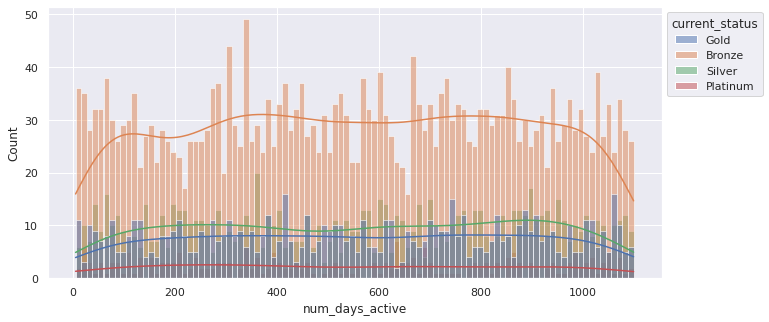

####################################################################################################
min_purchase_amount


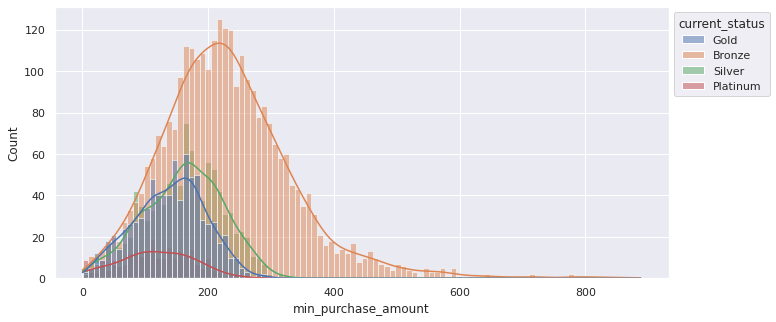

####################################################################################################
avg_purchase_amount


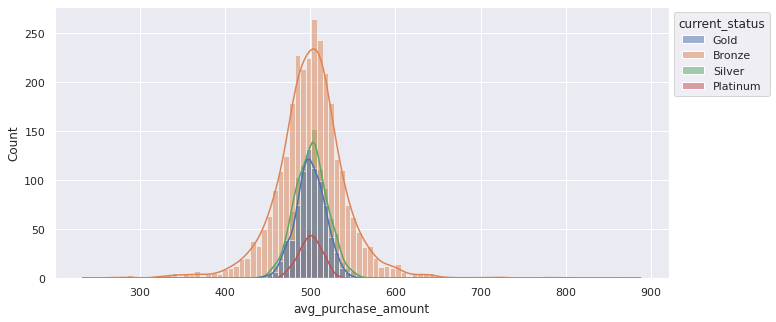

####################################################################################################
q75_purchase_amount


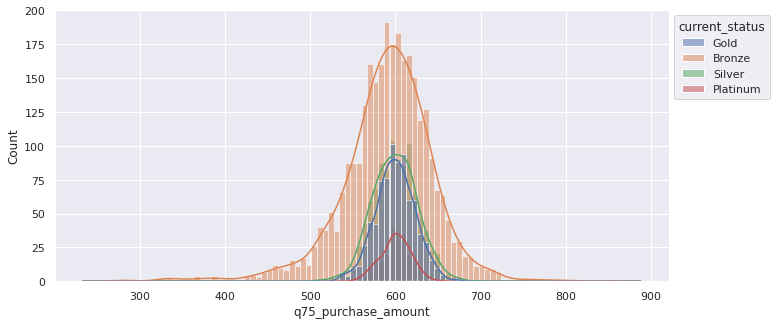

####################################################################################################
max_purchase_amount


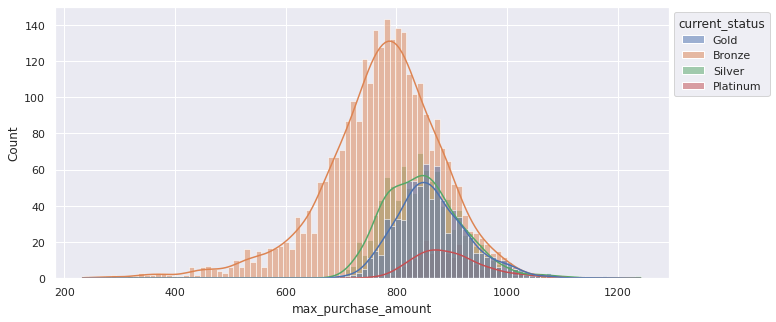

####################################################################################################
num_returns


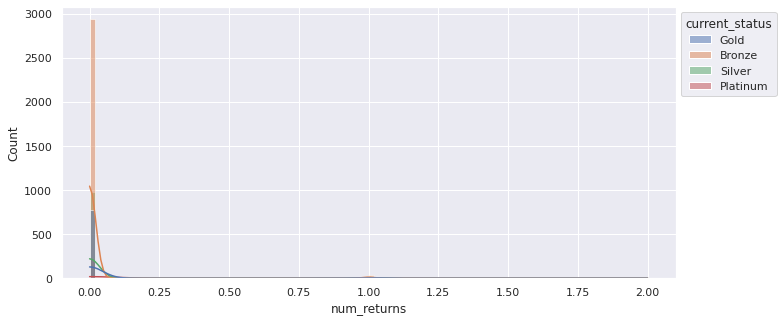

####################################################################################################
num_very_low


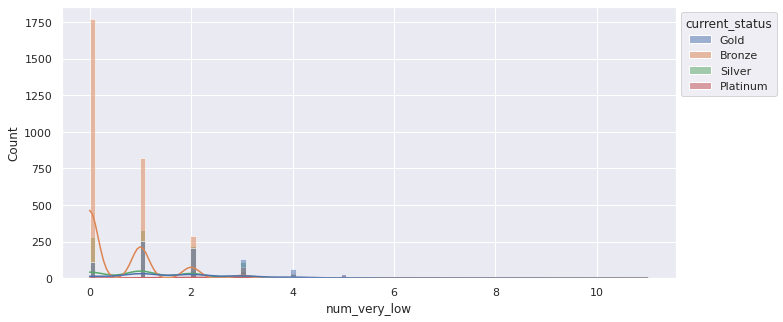

####################################################################################################
num_low


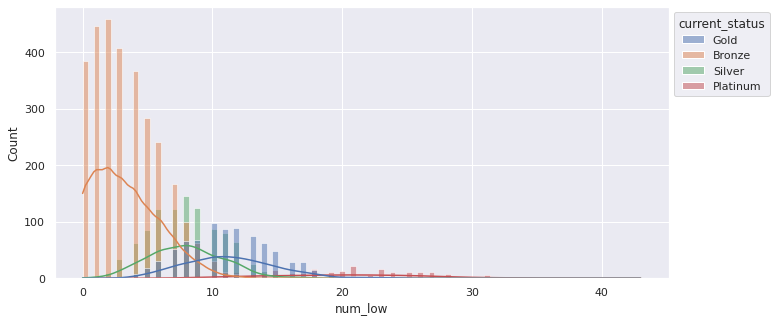

####################################################################################################
num_moderate


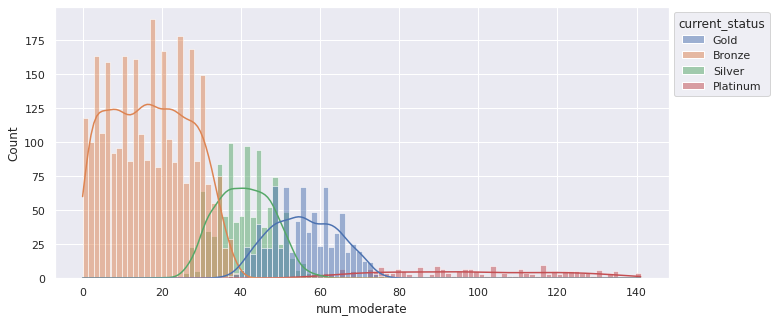

####################################################################################################
num_high


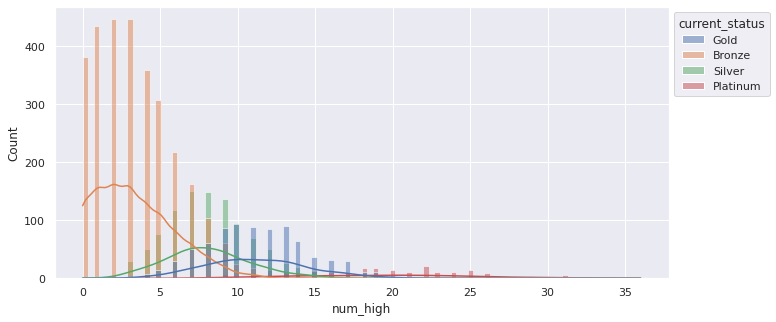

####################################################################################################
num_very_high


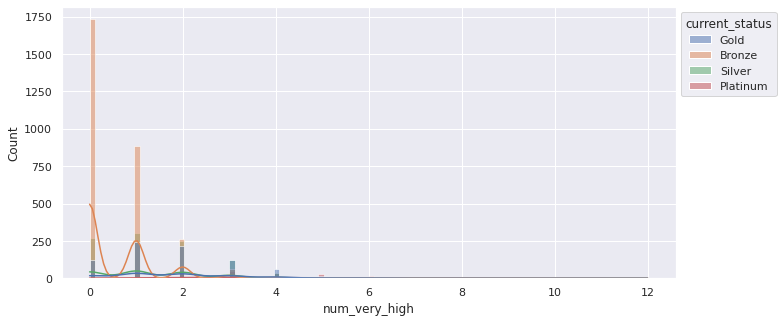

####################################################################################################
avg_time_spent


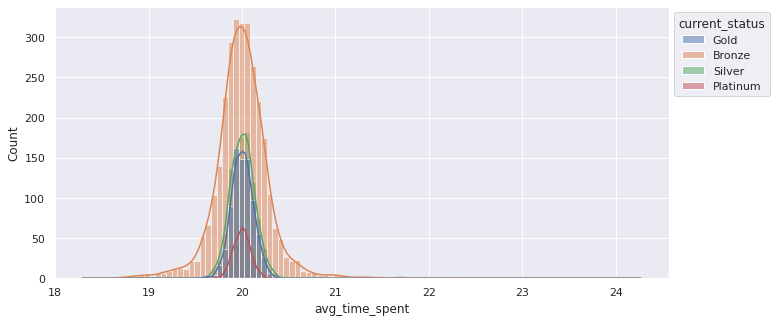

####################################################################################################
total_time_spent


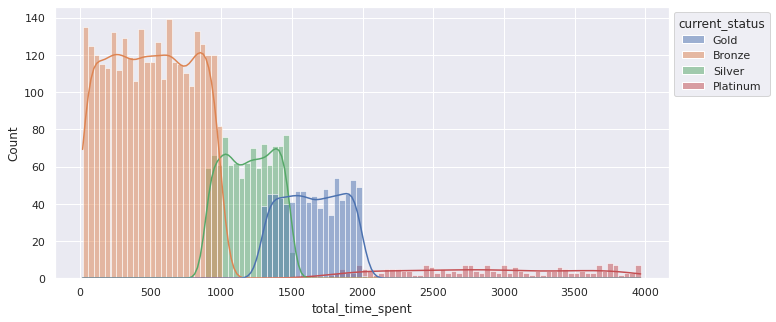

In [ ]:
for feature in feature_columns:
    print("#"*100)
    print(feature)
    ax = sns.histplot(x=feature, bins=100, kde=True, hue="current_status", data=customer_features)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

## Modeling

### Data

In [ ]:
feature_columns

['num_days_active',
 'min_purchase_amount',
 'avg_purchase_amount',
 'q75_purchase_amount',
 'max_purchase_amount',
 'num_returns',
 'num_very_low',
 'num_low',
 'num_moderate',
 'num_high',
 'num_very_high',
 'avg_time_spent',
 'total_time_spent']

In [ ]:
customer_features.describe()

,customer_id,num_days_active,min_purchase_amount,avg_purchase_amount,q75_purchase_amount,max_purchase_amount,num_returns,num_very_low,num_low,num_moderate,num_high,num_very_high,avg_time_spent,total_time_spent,label
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,3499.500000,554.842400,197.414462,500.814886,594.127832,808.860879,0.020400,1.048600,6.358000,31.928400,6.323400,1.073800,20.003069,935.152806,0.852200
std,1443.520003,316.919928,99.933371,37.203713,46.103548,104.017820,0.142786,1.262124,5.309828,23.483968,5.136778,1.307171,0.253047,683.666417,1.190562
min,1000.000000,5.000000,0.519327,232.814758,232.814758,232.814758,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.293942,18.593640,0.000000
25%,2249.750000,286.000000,132.038974,484.272689,573.685742,757.440264,0.000000,0.000000,2.000000,15.000000,2.000000,0.000000,19.889695,423.114586,0.000000
50%,3499.500000,560.000000,185.238227,501.116079,597.302063,817.178142,0.000000,1.000000,5.000000,28.000000,5.000000,1.000000,20.000038,839.578120,0.000000
75%,4749.250000,832.000000,247.181369,517.052514,619.054344,874.121048,0.000000,2.000000,9.000000,45.000000,9.000000,2.000000,20.109271,1336.834214,1.000000
max,5999.000000,1100.000000,887.856977,887.856977,887.856977,1241.386682,2.000000,11.000000,43.000000,141.000000,36.000000,12.000000,24.265878,3967.808952,3.000000


In [ ]:
target_column = "label"
X = customer_features[feature_columns]
y = customer_features[target_column]


### Polynomial **Features**

In [ ]:

orig_columns = X.columns
new_columns = list(combinations(orig_columns, 2))
new_column_names = ["__".join(col) for col in new_columns]

In [ ]:
poly = PolynomialFeatures(interaction_only=True, include_bias=False)
X = poly.fit_transform(X)

X = pd.DataFrame(X, columns=list(orig_columns) + new_column_names)

In [ ]:
zero_indices = [i for i,x in enumerate(list((X == 0).all())) if x]
X = X.drop(X.columns[zero_indices], axis=1)

### Train Test Split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, stratify=y, random_state=42)

In [ ]:
print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)

Train: (3350, 91) (3350,)
Test: (1650, 91) (1650,)


In [ ]:
label_split = pd.Series(le.inverse_transform(y_train)).value_counts().to_frame()
label_split["test"] = pd.Series(le.inverse_transform(y_test)).value_counts()
label_split.columns = ["train", "test"]
label_split

,train,test
Bronze,1990,980
Silver,668,329
Gold,533,263
Platinum,159,78


In [ ]:
label_pct = pd.Series(le.inverse_transform(y_train)).value_counts(normalize=True).to_frame()
label_pct["test"] = pd.Series(le.inverse_transform(y_test)).value_counts(normalize=True)
label_pct.columns = ["train", "test"]
label_pct

,train,test
Bronze,0.594030,0.593939
Silver,0.199403,0.199394
Gold,0.159104,0.159394
Platinum,0.047463,0.047273


### Feature Selection

In [ ]:
num_top_features = 50
select = SelectKBest(chi2, k=num_top_features).fit(X_train, y_train)
indices_selected = select.get_support(indices=True)
selected_colnames = [X_train.columns[i] for i in indices_selected]

In [ ]:
chi2_scores = pd.DataFrame(
    {'feature': X_train.columns,
     'chi2_score': select.scores_,
    })
chi2_scores.sort_values(by="chi2_score", ascending=False, inplace=True)
chi2_scores.head()

,feature,chi2_score
62,max_purchase_amount__total_time_spent,1.343861e+09
54,q75_purchase_amount__total_time_spent,8.416079e+08
24,num_days_active__total_time_spent,7.752625e+08
45,avg_purchase_amount__total_time_spent,6.952565e+08
84,num_moderate__total_time_spent,3.061060e+08


In [ ]:
X_train_selected = X_train[selected_colnames]
X_test_selected = X_test[selected_colnames]

In [ ]:
train_df_for_display = X_train_selected.copy()
train_df_for_display["current_status"] = le.inverse_transform(y_train)

####################################################################################################
max_purchase_amount__total_time_spent


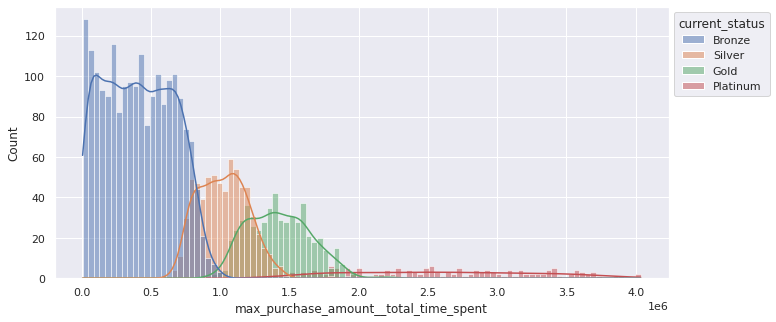

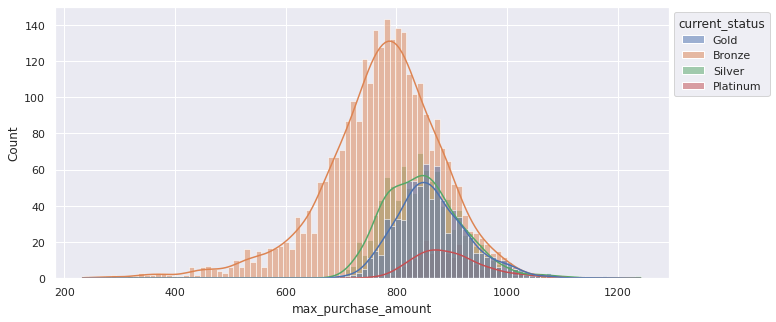

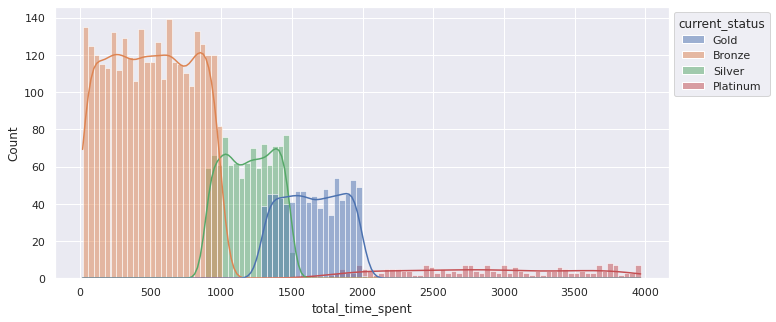

####################################################################################################
q75_purchase_amount__total_time_spent


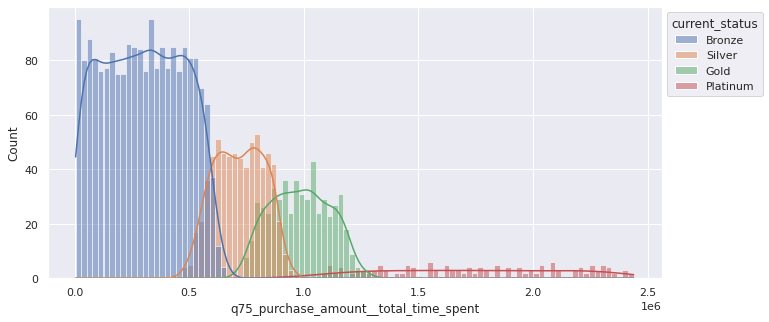

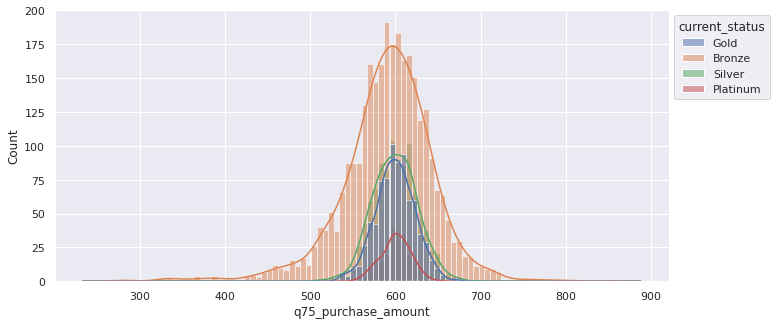

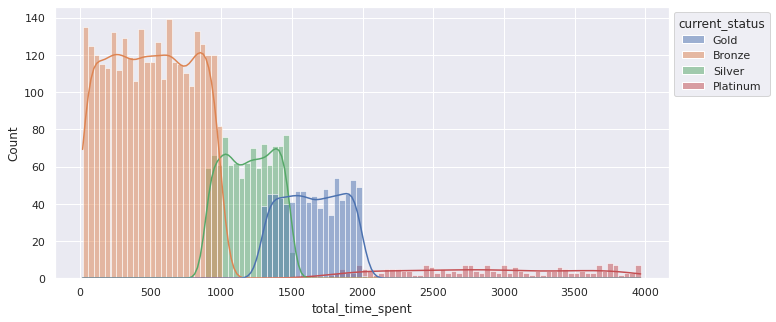

####################################################################################################
num_days_active__total_time_spent


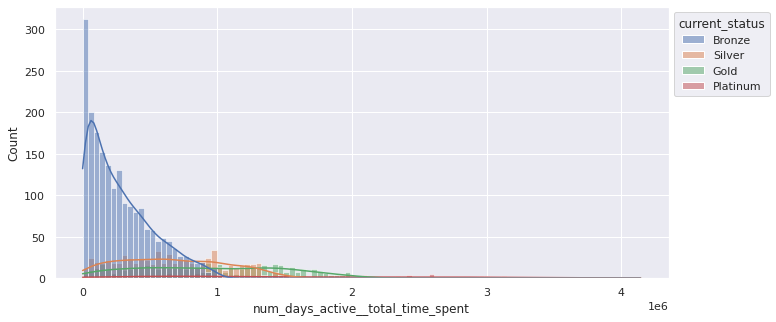

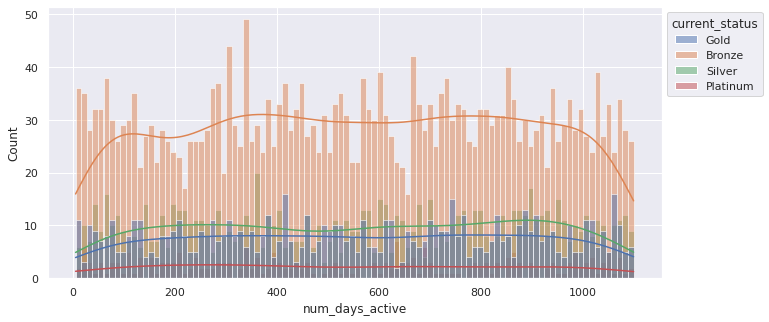

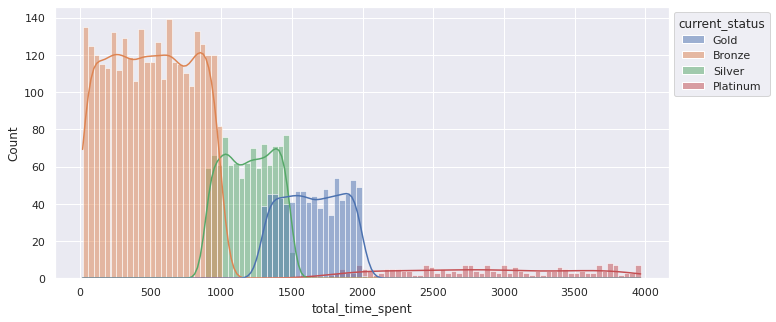

####################################################################################################
avg_purchase_amount__total_time_spent


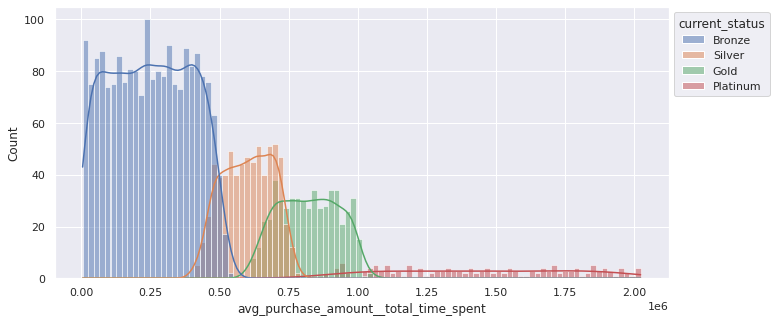

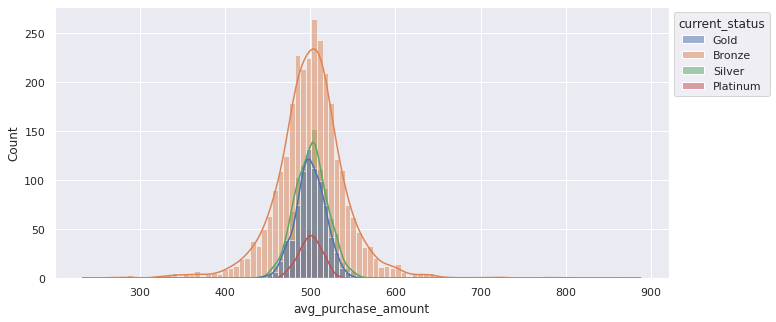

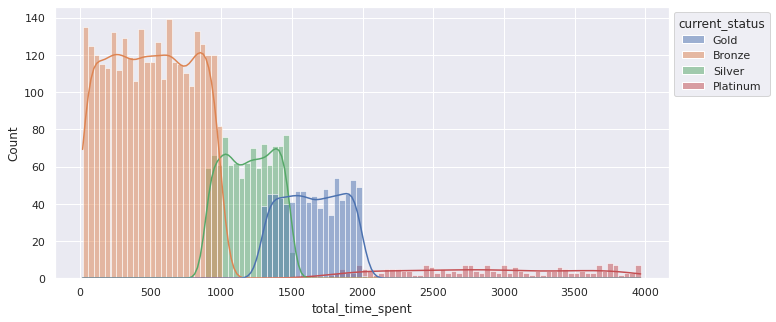

####################################################################################################
num_moderate__total_time_spent


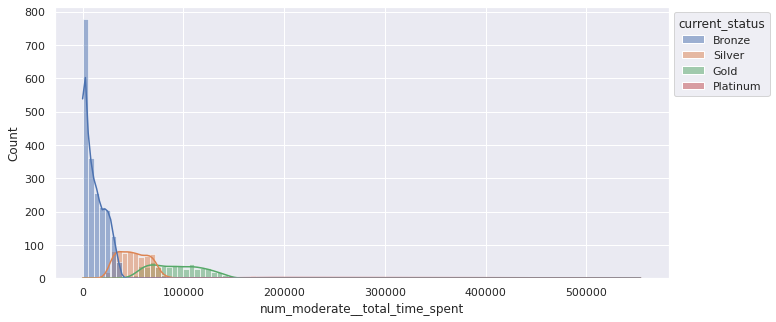

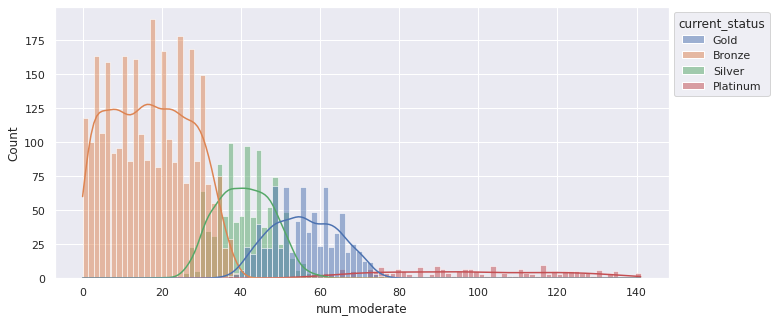

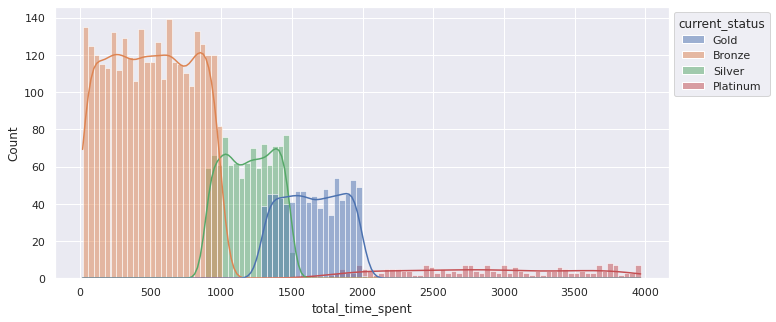

In [ ]:
for feature in chi2_scores.head()["feature"]:
    print("#"*100)
    print(feature)
    ax = sns.histplot(x=feature, bins=100, kde=True, hue="current_status", data=train_df_for_display)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ft1, ft2 = feature.split("__") 
    ax = sns.histplot(x=ft1, bins=100, kde=True, hue="current_status", data=customer_features)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

    ax = sns.histplot(x=ft2, bins=100, kde=True, hue="current_status", data=customer_features)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

### Model

#### Decision Tree

In [ ]:
clf = DecisionTreeClassifier(max_depth=5).fit(X_train_selected, y_train)
y_pred_dt = clf.predict(X_test_selected)


In [ ]:
ft_imp_df_dt = pd.DataFrame({"feature": selected_colnames,
                          "importance": clf.feature_importances_})
ft_imp_df_dt.sort_values("importance", ascending=False)
ft_imp_df_dt = pd.merge(ft_imp_df_dt, chi2_scores.head(num_top_features), on="feature", how="inner")
ft_imp_df_dt

,feature,importance,chi2_score
0,total_time_spent,0.862262,1.398257e+06
1,num_days_active__min_purchase_amount,0.000000,1.605518e+07
2,num_days_active__max_purchase_amount,0.000000,4.846275e+06
3,num_days_active__num_very_low,0.000000,8.016138e+05
4,num_days_active__num_low,0.000000,5.677959e+06
5,num_days_active__num_moderate,0.000000,2.625029e+07
6,num_days_active__num_high,0.000000,5.222245e+06
7,num_days_active__num_very_high,0.000000,8.155667e+05
8,num_days_active__total_time_spent,0.000596,7.752625e+08
9,min_purchase_amount__avg_purchase_amount,0.000000,1.578698e+07


In [ ]:
stats.kendalltau(ft_imp_df_dt["importance"], ft_imp_df_dt["chi2_score"])

KendalltauResult(correlation=0.06502794770195784, pvalue=0.5601182880073535)

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_dt )
df_cm = pd.DataFrame(cm_numpy, index = [f"Actual: {i}" for i in target_values],
                  columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,971,0,0,9,980
Actual: Gold,0,197,1,65,263
Actual: Platinum,0,8,70,0,78
Actual: Silver,64,21,0,244,329


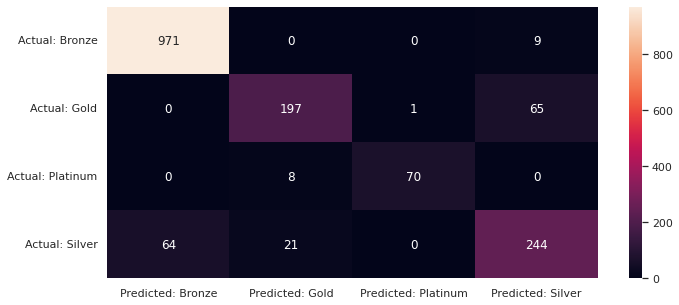

In [ ]:
sns.heatmap(df_cm[[f"Predicted: {i}" for i in target_values]], annot=True, fmt='g')

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_dt)
avg_precision, avg_recall, avg_f1, avg_support = precision_recall_fscore_support(y_test, y_pred_dt, average="weighted")
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df = performance_df.append({"class": "Weighted Average", 
                                        "precision": avg_precision,
                                        "recall": avg_recall,
                                        "f1": avg_f1,
                                        },
                                        ignore_index=True
                                        )
performance_df

,class,precision,recall,f1
0,Bronze,0.938164,0.990816,0.963772
1,Gold,0.871681,0.749049,0.805726
2,Platinum,0.985915,0.897436,0.939597
3,Silver,0.767296,0.741641,0.754250
4,Weighted Average,0.895754,0.898182,0.895660


In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred_dt))

Accuracy:  0.8981818181818182


#### Random Forest

In [ ]:
clf = RandomForestClassifier(n_estimators=100,
                             max_depth=5,
                             random_state=42).fit(X_train_selected, y_train)
y_pred_rf = clf.predict(X_test_selected)

In [ ]:
ft_imp_df_rf = pd.DataFrame({"feature": selected_colnames,
                             "importance": clf.feature_importances_})
ft_imp_df_rf.sort_values("importance", ascending=False)
ft_imp_df_rf = pd.merge(ft_imp_df_rf, chi2_scores.head(num_top_features), on="feature", how="inner")
ft_imp_df_rf

,feature,importance,chi2_score
0,total_time_spent,0.126208,1.398257e+06
1,num_days_active__min_purchase_amount,0.000505,1.605518e+07
2,num_days_active__max_purchase_amount,0.000522,4.846275e+06
3,num_days_active__num_very_low,0.000657,8.016138e+05
4,num_days_active__num_low,0.000993,5.677959e+06
5,num_days_active__num_moderate,0.000944,2.625029e+07
6,num_days_active__num_high,0.000601,5.222245e+06
7,num_days_active__num_very_high,0.000245,8.155667e+05
8,num_days_active__total_time_spent,0.001391,7.752625e+08
9,min_purchase_amount__avg_purchase_amount,0.000551,1.578698e+07


In [ ]:
stats.kendalltau(ft_imp_df_rf["importance"], ft_imp_df_rf["chi2_score"])

KendalltauResult(correlation=0.2897959183673469, pvalue=0.0029826102003796644)

In [ ]:
stats.kendalltau(ft_imp_df_dt["importance"], ft_imp_df_rf["importance"])

KendalltauResult(correlation=0.34014618797947177, pvalue=0.0023053063420010716)

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_rf, )
df_cm = pd.DataFrame(cm_numpy, index = [f"Actual: {i}" for i in target_values],
                  columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,976,0,0,4,980
Actual: Gold,0,204,0,59,263
Actual: Platinum,0,9,69,0,78
Actual: Silver,60,21,0,248,329


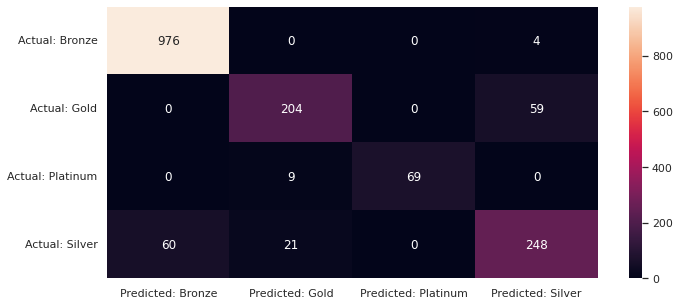

In [ ]:
sns.heatmap(df_cm[[f"Predicted: {i}" for i in target_values]], annot=True, fmt='g')

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_rf)
avg_precision, avg_recall, avg_f1, avg_support = precision_recall_fscore_support(y_test, y_pred_rf, average="weighted")
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df = performance_df.append({"class": "Weighted Average", 
                                        "precision": avg_precision,
                                        "recall": avg_recall,
                                        "f1": avg_f1,
                                        },
                                        ignore_index=True
                                        )
performance_df

,class,precision,recall,f1
0,Bronze,0.942085,0.995918,0.968254
1,Gold,0.871795,0.775665,0.820926
2,Platinum,1.000000,0.884615,0.938776
3,Silver,0.797428,0.753799,0.775000
4,Weighted Average,0.904775,0.907273,0.904844


In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred_rf))

Accuracy:  0.9072727272727272


#### Naive Bayes

In [ ]:
clf = GaussianNB().fit(X_train_selected, y_train)
y_pred_nb = clf.predict(X_test_selected)

In [ ]:
# ft_imp_df = pd.DataFrame({"feature": selected_colnames,
#                           "importance": clf.feature_importances_})
# ft_imp_df.sort_values("importance", ascending=False)
# ft_imp_df = pd.merge(ft_imp_df, chi2_scores.head(20), on="feature", how="inner")
# ft_imp_df

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_nb)
df_cm = pd.DataFrame(cm_numpy, index = [f"Actual: {i}" for i in target_values],
                  columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,860,0,0,120,980
Actual: Gold,0,218,1,44,263
Actual: Platinum,0,10,68,0,78
Actual: Silver,10,41,0,278,329


In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_nb)
avg_precision, avg_recall, avg_f1, avg_support = precision_recall_fscore_support(y_test, y_pred_nb, average="weighted")
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df = performance_df.append({"class": "Weighted Average", 
                                        "precision": avg_precision,
                                        "recall": avg_recall,
                                        "f1": avg_f1,
                                        },
                                        ignore_index=True
                                        )
performance_df

,class,precision,recall,f1
0,Bronze,0.988506,0.877551,0.929730
1,Gold,0.810409,0.828897,0.819549
2,Platinum,0.985507,0.871795,0.925170
3,Silver,0.628959,0.844985,0.721141
4,Weighted Average,0.888285,0.863030,0.870361


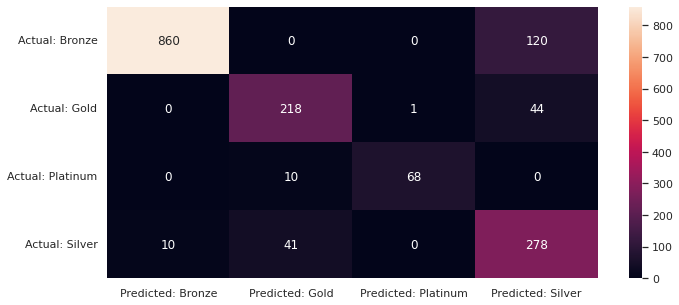

In [ ]:
sns.heatmap(df_cm[[f"Predicted: {i}" for i in target_values]], annot=True, fmt='g')

In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred_nb))

Accuracy:  0.863030303030303


#### SVC

In [ ]:
clf = SVC().fit(X_train_selected, y_train)
y_pred_svc = clf.predict(X_test_selected)

In [ ]:
# ft_imp_df = pd.DataFrame({"feature": selected_colnames,
#                           "importance": imps.importances_mean})
# ft_imp_df.sort_values("importance", ascending=False)
# ft_imp_df = pd.merge(ft_imp_df, chi2_scores.head(20), on="feature", how="inner")
# ft_imp_df

In [ ]:
cm_numpy = confusion_matrix(y_test, y_pred_svc)
df_cm = pd.DataFrame(cm_numpy, 
                     index = [f"Actual: {i}" for i in target_values],
                     columns = [f"Predicted: {i}" for i in target_values])
df_cm["Total"] = df_cm.T.sum()
df_cm

,Predicted: Bronze,Predicted: Gold,Predicted: Platinum,Predicted: Silver,Total
Actual: Bronze,974,0,0,6,980
Actual: Gold,0,215,0,48,263
Actual: Platinum,0,10,68,0,78
Actual: Silver,60,31,0,238,329


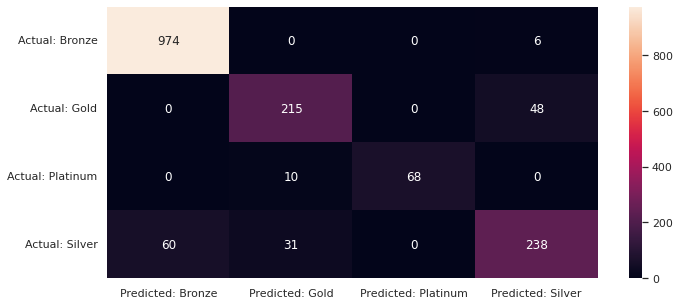

In [ ]:
sns.heatmap(df_cm[[f"Predicted: {i}" for i in target_values]], annot=True, fmt='g')

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(y_test, y_pred_svc)
avg_precision, avg_recall, avg_f1, avg_support = precision_recall_fscore_support(y_test, y_pred_svc, average="weighted")
performance_df = pd.DataFrame({"precision": precision.tolist(),
                                "recall": recall.tolist(),
                                "f1": f1.tolist()
                                })
performance_df = performance_df.reset_index()
performance_df.columns = ["class", "precision", "recall", "f1"]
performance_df["class"] = le.inverse_transform(performance_df["class"])
performance_df = performance_df.append({"class": "Weighted Average", 
                                        "precision": avg_precision,
                                        "recall": avg_recall,
                                        "f1": avg_f1,
                                        },
                                        ignore_index=True
                                        )
performance_df

,class,precision,recall,f1
0,Bronze,0.941973,0.993878,0.967229
1,Gold,0.839844,0.817490,0.828516
2,Platinum,1.000000,0.871795,0.931507
3,Silver,0.815068,0.723404,0.766506
4,Weighted Average,0.903133,0.906061,0.903408


In [ ]:
print("Accuracy: ", accuracy_score(y_test, y_pred_svc))

Accuracy:  0.906060606060606
